In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# training set
Our training set is a simple Gaussian distribution, which means that we consider them as a real data. In fact, our discriminator will evaluate the fake data that are produced by the generator (Quantum Circuit) by the real data.

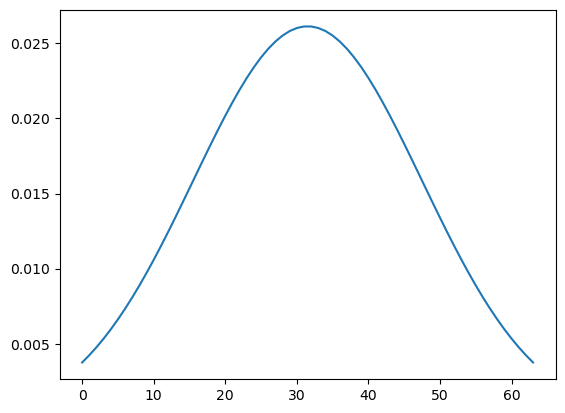

In [105]:
def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(2**num_bit)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

num_bit = 6
pg = gaussian_pdf(num_bit, mu=2**5-0.5, sigma=2**4)
plt.plot(pg)
plt.show()

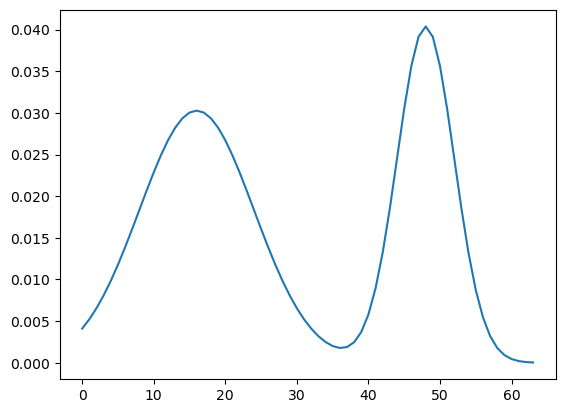

In [106]:
import numpy as np

def bimodal_gaussian_pdf(num_bits, mu1, sigma1, mu2, sigma2, weight1=0.5):
    '''Get bimodal Gaussian distribution function'''
    x = np.arange(2**num_bits)
    
    # Calculate the PDFs for the two Gaussian distributions
    pdf1 = 1. / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-(x - mu1)**2 / (2. * sigma1**2))
    pdf2 = 1. / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-(x - mu2)**2 / (2. * sigma2**2))
    
    # Combine the PDFs using the specified weight for each distribution
    pl = weight1 * pdf1 + (1 - weight1) * pdf2
    
    return pl / np.sum(pl)

# Example usage:
num_bits = 6
mu1 = 2**num_bits / 4  # Set the mean of the first peak
sigma1 = 2**num_bits / 8  # Adjust the standard deviation of the first peak as needed
mu2 = 3 * 2**num_bits / 4  # Set the mean of the second peak
sigma2 = 2**num_bits / 16  # Adjust the standard deviation of the second peak as needed
weight1 = 0.6  # Set the weight for the first peak (between 0 and 1)
pdf = bimodal_gaussian_pdf(num_bits, mu1, sigma1, mu2, sigma2, weight1)
plt.plot(pdf)

# Build Circuits
## Building Blocks
Define matrix representations of operations using scipy sparse matrices.
They are grouped to become a layer in a circuit, this layer can be `ArbitraryRotation` or `CNOTEntangler`.
Which are used as our basic building blocks of our `Born Machines`.

In [149]:
######  Pauli Matrices  ########
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2   #projection operator to |0><0|
p1 = (-sz + I2) / 2

# single bit rotation matrices
def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return _ri(sz, t3).dot(_ri(sx, t2)).dot(_ri(sz, t1))

# multiple bit construction
def CNOT(ibit, jbit, n):
    '''
    CNOT gate
    
    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.
        
    Returns:
        4x4 csr_matrix: CNOT matrix.
    '''
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    notice the last bit is the high end bit!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res


def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [150]:
class ArbitraryRotation(object):
    '''Arbitrary rotation gate'''
    def __init__(self, num_bit):
        self.num_bit = num_bit
        # mask is used to filter out some irrelevant (marked False) parameters
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    '''
    CNOT Entangler Layer.
    
    Args:
        pairs (list): a list of tuples to represent connections.
    '''
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

# Circuit
A circuit is consist of queued layers, here this data structure is `BlockQueue`. A `BlockQueue` uses `theta_last` and `memo` attributes to cache sparse operators, this will accelerate simulation significantly.

In [151]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    
    Attributes:
        theta_last (1darray): the cached circuit parameters.
        memo (list): cached sparse matrices for layers.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        '''
        Apply operations on vector basis: qureg. This operation changes vector inplace.
        
        Args:
            qureg (1darray): vector basis.
            theta_list (1darray): circuit parameters:
        '''
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrices update method.
    
    Args:
        layer (ArbitraryRotation): rotation layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        list of csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [152]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs.'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_demo_circuit(num_bit, depth, pairs):
    '''Get the circuit used for demo'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [153]:
# let's see how this circuit look like
depth = 6
pairs = get_nn_pairs(num_bit)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

[<__main__.ArbitraryRotation object at 0x7f74ca5e2710>, <__main__.CNOTEntangler object at 0x7f74ca57a170>, <__main__.ArbitraryRotation object at 0x7f74ca57a230>, <__main__.CNOTEntangler object at 0x7f74ca57bc70>, <__main__.ArbitraryRotation object at 0x7f74ca578220>, <__main__.CNOTEntangler object at 0x7f74ca5798a0>, <__main__.ArbitraryRotation object at 0x7f74ca57b4f0>, <__main__.CNOTEntangler object at 0x7f74cb902a10>, <__main__.ArbitraryRotation object at 0x7f74cb900670>, <__main__.CNOTEntangler object at 0x7f74cb603670>, <__main__.ArbitraryRotation object at 0x7f74ca5a4070>, <__main__.CNOTEntangler object at 0x7f74ca413cd0>, <__main__.ArbitraryRotation object at 0x7f74ca413e80>]


In [154]:
# let's see how this circuit works
# rotating the last bit along x axis by pi/2.
theta_list = np.zeros(circuit.num_param)
theta_list[-1] = np.pi/2.

wf = initial_wf(num_bit)
circuit(wf, theta_list)

# now you see the last bit is the high end bit!
print(wf)

[0.70710678+0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        -0.70710678j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j


# Maximum mean Discrepancy (MMD) Loss Function
Basically, loss function will tell us how well the model is doing. There are different forms of the loss functions that we use them depend on the situation. In this article the idea is to compare the distance in the kernel feature space on the samples drawn from the target and the model distributions.
We refer the following loss function as the squared `Maximum Mean Discrepancy` (MMD).


As a reminder
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2  =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}


In [155]:
class RBFMMD2(object):
    '''
    MMD^2 with RBF (Gaussian) kernel.
    
    Args:
        sigma_list (list): a list of bandwidths.
        basis (1darray): defininng space.
      
    Attributes:
        K (2darray): full kernel matrix, notice the Hilbert is countable.
    '''
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float: loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        '''
        expectation value of kernel function.
        
        Args:
            px (1darray): the first PDF.
            py (1darray): the second PDF.
            
        Returns:
            float: kernel expectation.
        '''
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.
    
    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.
        
    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

<span style='color:red'> It would be interesting to mentioned that in MMD loss function we compare the difference between the real data and fake data.  <span>  

<span style= 'color:green'>In the following examples we can see that this loss function work correctly so that when we choose same wave function, the value of the loss function is zero and in contrast, when we choose different wave function we can see that their Kernels have different results and consequently their loss function is non-zero<span>

In [156]:
hndim = 2**num_bit
# mmd loss
mmd = RBFMMD2(sigma_list=[0.25,4], basis=np.arange(2**num_bit))

# when exact match, MMD loss should be 0, e.g. two gaussians
print('Exact Match -> MMD = %.4f'%mmd(pg, pg))
# when not match, loss is not zero
prand = np.random.random(len(pg))
print('Not Match -> MMD = %.4f'%mmd(prand/prand.sum(), pg))

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

# Build The Gradient training framework for Born Machine
To learn the QCBM as a generative model, we compute gradient of the loss function with respect to the circuit parameters. We have got to minimize the `Maximum mean Discrepancy(MMD)` and for this we should use the gradient of MMD loss as follow
\begin{align}
\frac{\partial \mathcal{L}}{\partial \theta_l^i} &= \langle K(x,y) \rangle_{x \sim p_{\theta^+}, y \sim p_\theta} - \langle K(x,y) \rangle_{x \sim p_{\theta^-}, y \sim p_\theta} - \langle K(x,y) \rangle_{x \sim p_{\theta^+}, y \sim \pi} + \langle K(x,y) \rangle_{x \sim p_{\theta^-}, y \sim \pi}.
\end{align}


In [ ]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine framework,

    Args:
        circuit (BlockQueue): the circuit architechture.
        mmd (RBFMMD2): maximum mean discrepancy.
        p_data (1darray): data probability distribution in computation basis.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        '''defined by the number of entanglers'''
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''
        get probability distribution function.
        
        Args:
            theta_list (1darray): circuit parameters.
            
        Returns:
            1darray: probability distribution function.
        '''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl))
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x ~ pl.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim):
    '''
    emperical probability from data.
    '''
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [ ]:
# Born Machine
bm = QCBM(circuit, mmd, pg, batch_size=None)  # exact version

In [ ]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
print('MMD loss for Initial Circuit = %.4f'%bm.mmd_loss(theta_list))

MMD loss for Initial Circuit = 0.0687


In [ ]:
# gradient test
# these two gradients should match.
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[-1.83973860e-02 -1.69394107e-03 -1.94013918e-02 -2.83250180e-03
 -2.60034909e-03  2.66280141e-02 -1.42444380e-04 -8.07408406e-03
  1.24341533e-02  7.41247233e-04 -4.11679589e-04 -3.72802520e-03
  2.33789007e-02  1.25714017e-02  2.13184799e-02  1.73193607e-02
  3.64863811e-03  2.07948875e-02  6.07939609e-03  2.76168107e-03
  6.89108876e-03  6.23669020e-03 -7.64564334e-03  3.79458867e-03
  2.31583329e-03 -2.58380509e-02  2.77679436e-03  2.02273944e-02
  1.78480649e-02  2.05818254e-02  1.31137260e-02 -1.30986333e-02
 -1.72383309e-02 -7.46854450e-03 -9.83736516e-03  4.55475491e-03
 -5.87561172e-04  2.58894298e-03 -1.01951078e-03  2.04798454e-02
  2.80151492e-03 -6.57573372e-03 -9.74580395e-03  9.24629789e-03
 -3.63360890e-03  1.07469883e-02 -1.93864307e-02 -7.30237498e-03
 -2.53580558e-02  1.74945319e-02 -1.28862980e-02  5.62608883e-04
 -1.05548442e-02 -9.90119662e-03 -8.00857774e-03  7.94780598e-03
 -9.33079418e-03 -1.07099104e-02  1.64436009e-02 -2.50407721e-02
  1.31512910e-02  7.64871

# Training
In this basic introduction, I prepaired classical training method like `Adam` and `L-BFGS-B` (as well as other methods supported by scipy).

In [ ]:
  def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.
    
    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('Adam'|'L-BFGS-B'):
            * L-BFGS-B: efficient, but not noise tolerant.
            * Adam: noise tolerant.
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.
        
    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

`L-BFGS-B optimizer is used `

step = 1, loss = 0.018644936310878595
step = 2, loss = 0.010987753490711974
step = 3, loss = 0.007491715864668538
step = 4, loss = 0.00569387178322024
step = 5, loss = 0.004403793158807703
step = 6, loss = 0.003120657610836384
step = 7, loss = 0.0023970826990913525
step = 8, loss = 0.0017374665216731253
step = 9, loss = 0.001224861433642394
step = 10, loss = 0.0009421954580513524
step = 11, loss = 0.000695063197659883
step = 12, loss = 0.0004886956790203475
step = 13, loss = 0.00037070327935917664
step = 14, loss = 0.00028015027998968064
step = 15, loss = 0.00023027406104306436
step = 16, loss = 0.00018862026462320987
step = 17, loss = 0.00016521180653498904
step = 18, loss = 0.00014586682502964037
step = 19, loss = 0.0001324121877701667
step = 20, loss = 0.0001200009062370115


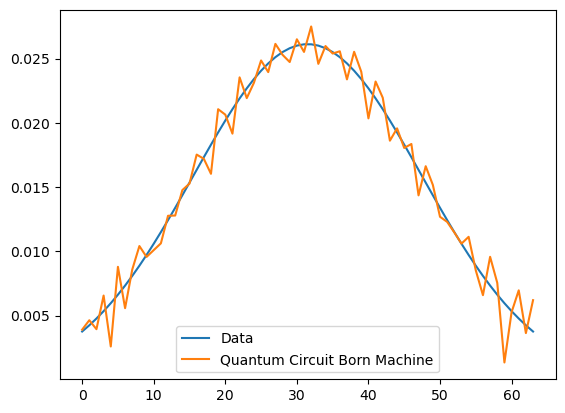

In [ ]:
# random initial parameter
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display training result
plt.plot(bm.p_data) # this is the real data
plt.plot(pl) # this is the fake data
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.show()

`Adam metoptimizer is used`

step = 1, loss = 0.027373788662559476
step = 2, loss = 0.011988357204244508
step = 3, loss = 0.017210150468131662
step = 4, loss = 0.014580931624111684
step = 5, loss = 0.010634143503276364
step = 6, loss = 0.008674440367761048
step = 7, loss = 0.0067454083388377535
step = 8, loss = 0.005721659796682355
step = 9, loss = 0.006526811882775539
step = 10, loss = 0.006462325075604548
step = 11, loss = 0.004621442065296688
step = 12, loss = 0.0032075653132176652
step = 13, loss = 0.0032639698963284783
step = 14, loss = 0.0041176510440047945
step = 15, loss = 0.003530946576032501
step = 16, loss = 0.0022988133606571563
step = 17, loss = 0.0019096715225448684
step = 18, loss = 0.001864642434035307
step = 19, loss = 0.0016242407648785775
step = 20, loss = 0.0016293136808842618


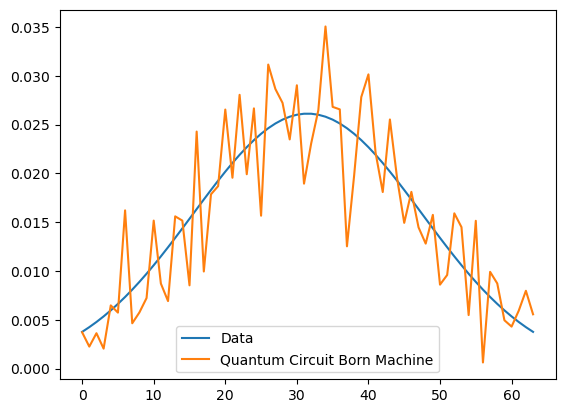

In [ ]:
# random initial parameter
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

loss, theta_list = train(bm, theta_list, 'Adam', max_iter=20)
pl = bm.pdf(theta_list)

# display training result
plt.plot(bm.p_data) # this is the real data
plt.plot(pl) # this is the fake data
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.show()